In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.9713307112803444

In [6]:
import tensorflow as tf

c:\users\anusha\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 3
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            
            loss = tf.clip_by_value(loss, -1e-4, 1e-4)
            loss = tf.where(tf.is_nan(loss), 1e-4, loss)
            loss = tf.where(tf.equal(loss, -1e-4), tf.random_normal(loss.shape), loss)
            loss = tf.where(tf.equal(loss, 1e-4), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()

In [8]:
import collections
import time
import sklearn.metrics as me 


class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd-/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e9 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd-/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd-/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]



    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.predictions_ = {}

        Train.results = []
        
        features_arr = [30]
        hidden_layers_arr = [1, 3]

        epochs = [10]
        lrs = [1e-4]

        print("********************************** Entering Loop ******************************")

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        if not os.path.isfile('dataset/scores/tf_vae_only_nsl_kdd_ally49-.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_ally49-.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
            
        past_scores.to_pickle("dataset/scores/tf_vae_only_nsl_kdd_ally49-.pkl")

In [10]:
Hyperparameters.start_training()

********************************** Entering Loop ******************************
Current Layer Attributes - epochs:10 hidden layers:1 features count:30
Step 1 | Training Loss: -0.544857 | Validation Accuracy: 0.439683
Accuracy on Test data: 0.42459189891815186, 0.41358649730682373
Step 2 | Training Loss: -1.578996 | Validation Accuracy: 0.437302
Accuracy on Test data: 0.4256564974784851, 0.4190717339515686
Step 3 | Training Loss: -0.429924 | Validation Accuracy: 0.442063
Accuracy on Test data: 0.4204666316509247, 0.4072573781013489
Step 4 | Training Loss: -0.086317 | Validation Accuracy: 0.443254
Accuracy on Test data: 0.42206352949142456, 0.41696202754974365
Step 5 | Training Loss: 0.962396 | Validation Accuracy: 0.445635
Accuracy on Test data: 0.4213537871837616, 0.4080168902873993
Step 6 | Training Loss: 1.035879 | Validation Accuracy: 0.421032
Accuracy on Test data: 0.42525726556777954, 0.4094514846801758
Step 7 | Training Loss: -0.473507 | Validation Accuracy: 0.429365
Accuracy on 

In [11]:
pd.Panel(Train.predictions).to_pickle("dataset/VAE/tf_vae_only_nsl_kdd_predictionsy49.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/VAE/tf_vae_only_nsl_kdd_predictionsy49__.pkl")

df_results.to_pickle("dataset/VAE/tf_vae_only_nsl_kdd_scoresy49.pkl")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)

In [13]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_ally49-.pkl")

In [14]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
8,10,30,3,0.463492,0.557177,0.678020,0.692405,0.811189,33.833186
7,2,30,3,0.481349,0.556467,0.677961,0.695865,0.813419,3.655029
3,5,30,3,0.474206,0.521247,0.640461,0.642447,0.771405,16.748715
2,4,30,3,0.459127,0.520538,0.638555,0.642616,0.770548,12.765969
1,2,30,3,0.467063,0.513973,0.634779,0.648776,0.775996,5.302614
0,2,30,1,0.476587,0.483987,0.522631,0.468861,0.596435,3.463418
6,8,30,1,0.429365,0.426366,0.396828,0.406751,0.486861,13.857626
4,2,30,1,0.439683,0.424592,0.394850,0.413586,0.494214,2.101642
5,3,30,1,0.437302,0.425656,0.393990,0.419072,0.498762,4.436800


In [15]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
30             3                 10     0.463492    0.557177  0.678020   
               1                  2     0.476587    0.483987  0.522631   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
30             3                   0.692405     0.811189   33.833186  
               1                   0.468861     0.596435    3.463418

In [16]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
30             3               4.60     0.469048     0.53388  0.653955   
               1               3.75     0.445734     0.44015  0.427075   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
30             3                   0.664422     0.788511   14.461102  
               1                   0.427068     0.519068    5.964871

In [17]:
Train.predictions = pd.read_pickle("dataset/VAE/tf_vae_only_nsl_kdd_predictionsy49.pkl")
Train.predictions_ = pd.read_pickle("dataset/VAE/tf_vae_only_nsl_kdd_predictionsy49__.pkl")

In [18]:
Train.predictions

<class 'pandas.core.panel.Panel'>
Dimensions: 5 (items) x 22544 (major_axis) x 4 (minor_axis)
Items axis: 10_30_3 to 8_30_1
Major_axis axis: 0 to 22543
Minor_axis axis: Actual to Prediction

In [20]:
Train.predictions["10_30_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
4223,1.0,-0.388697,-0.053915,1.0


In [21]:
Train.predictions_["10_30_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
9340,1.0,-0.145961,-0.045786,1.0


In [22]:
df = Train.predictions["10_30_3"].dropna()
df_ = Train.predictions_["10_30_3"].dropna()

In [23]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}

In [25]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train-/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train-/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.557177,0.678020,0.578417,0.819060,Train-/Test+
1,0.692405,0.811189,0.815031,0.807383,Train-/Test-


In [26]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

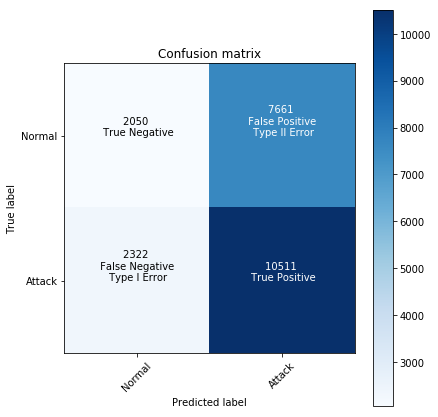

In [27]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [28]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

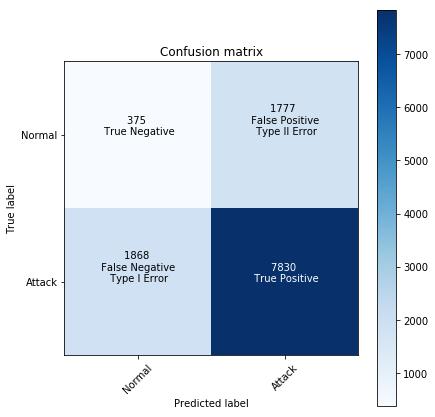

In [29]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))